Compare linesH points with lineDistH in length of arr. Then test EDA funcitonality
    

In [4]:
import cv2
import numpy as np
import torchvision.transforms as T

from sklearn.neighbors import KernelDensity
from objectDetection import *
from carMasking import *
from imgFeatureUtils import *

%matplotlib inline

forExt = DLForegroundExtractor(512)
videoPath = "/home/hector/speed/speed_DS/v1.mp4"

In [2]:
yolo = objectDetector((512,512),
                       weightPath="yolov3/weights/yolov3.weights",
                       modelDef="yolov3/config/yolov3.cfg")
viz = objectVisualizer(classPath="yolov3/data/coco.names")
tools = objectFocusTools((512,512),yolo)
linesDataset = []
cap = cv2.VideoCapture("/home/hector/speed/speed_DS/v5.avi")
lineSetH = []
lineSetV = []
distSetH = []
distSetV = []
thetaSetH = []
thetaSetV = []
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
else:
  ret, frame = cap.read()
  frame = cv2.resize(frame, (512,512))
  cv2.imwrite("camCal/data/background.jpg",frame )
while(cap.isOpened()):
  ret, frame = cap.read()
  if ret == True:
    frame = cv2.resize(frame, (512,512))
    grayFrame = convertImg2Grayscale(frame)

    #generate features from image
    #(-60,-40) vertical, (0,20) horizontal 
    linesV, edgeMap = tools.getObjectLinesAtFrame(frame,grayFrame,(-60,-40))
    linesH, edgeMap = tools.getObjectLinesAtFrame(frame, grayFrame, (0,20))
    lineDistH = getLinesEuclideanDist(linesH)
    lineDistV = getLinesEuclideanDist(linesV)
    thetasH = getLinesThetas(linesH)
    thetasV = getLinesThetas(linesV)

    #append features to containers
    lineSetH.append(linesH)
    lineSetV.append(linesV)
    distSetH.append(lineDistH)
    distSetV.append(lineDistV)
    thetaSetH.append(thetasH)
    thetaSetV.append(thetasV)

    #visualization
    empty = np.zeros((edgeMap.shape[0],edgeMap.shape[1],3))
    empty[:,:,0] = edgeMap
    #frameObjs = viz.drawBoxes(frame,detections)
    linesImg = drawLinesOnImg(empty, linesH)
    cv2.imshow('Frame',linesImg)
    if cv2.waitKey(25) & 0xFF == ord('q'):
      break
  else: 
    break

cap.release()
cv2.destroyAllWindows()

#flatten the featureset to get container of features, as the previous features were wrapped inside subarrays
lineSetH = flatten(lineSetH)
lineSetV = flatten(lineSetV)
distSetH = flatten(distSetH)
distSetV = flatten(distSetV)
thetaSetH = flatten(thetaSetH)
thetaSetV = flatten(thetaSetV)



In [5]:
from projectiveGeometry import *

lines = transform.probabilistic_hough_line(edgeMap, line_length=3,
                                           line_gap=2)
edgelets_road = compute_edgelets(lines)
vp_road = ransac_vanishing_point(edgelets_road, num_ransac_iter=2000, 
                             threshold_inlier=5)


A DISTANCE FILTERING SHOULD BE PERFORMED (HOW???)

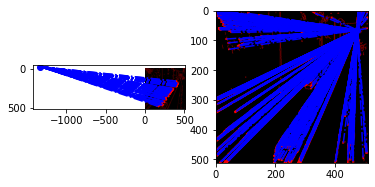

In [6]:

vp1, vp2 = compute2vps(lineSetH, lineSetV)
fig, (ax1, ax2) = plt.subplots(1,2)
vis_model(empty, lineSetH, vp1, ax=ax1, show=False)
vis_model(empty, lines, vp_road, ax=ax2, show=False)
plt.show()

## Now to compute camera parameters
Define a configuration object, then a calibration object passing the conf obj. Compute calibration matrix using closed form

In [12]:
import json
#constant real measure
distSetRealH = [1.5]*len(distSetH)
with open('camCal/data/cfg.json') as json_file:
    data = json.load(json_file)
    data["camCal"]["calVr"] = [int(vp_road[0]),int(vp_road[1])]
    data["camCal"]["calVl"] = [int(vp1[0]),int(vp1[1])]
    data["camCal"]["calMeasLnSegNdPt"] = list(map(lambda l: list(l),flatten(lineSetH)))[:10]
    data["camCal"]["calMeasLnSegDist"] = distSetRealH[:5]
    data["genInfo"]["inFrmPth"] = "camCal/data/background.jpg"
with open('camCal/data/cfg.json', "w") as json_file:
    json.dump(data, json_file)


In [6]:
print(len(list(map(lambda l: list(l),flatten(lineSetH)))))
print(len(distSetRealH))

822
411


In [5]:
from camCal.camCalObjs import CCfg
from camCal.EDAopt import CCamCal
vp1 = tuple(map(lambda x: int(x), vp1))
vp2 = tuple(map(lambda x: int(x), vp2))
vp1 = (vp1[1], vp1[0])
vp2 = (vp2[1], vp2[0])
configuration = CCfg(
    Vr=vp2[:2],
    Vl=vp1[:2],
    frameSize=(512,512),
    camHeightMax=5,
    camHeightMin=2,
    linePoints=lineSetH,
    lineDists=distSetRealH,
    optimize=False
)

calibrator = CCamCal(
    oCfg=configuration, 
    oImgBg=frame
)

In [6]:
calibrator.process((vp2[:2],vp1[:2]))

start
compCamParam
164777.00000000003
[nan nan nan nan nan nan nan nan nan nan nan nan]


KeyboardInterrupt: 